In [64]:
from __future__ import print_function
from fenics import *
from dolfin import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import pylab  
import random

In [65]:
parameters["form_compiler"]["cpp_optimize"] = True
ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

(3971, 2)


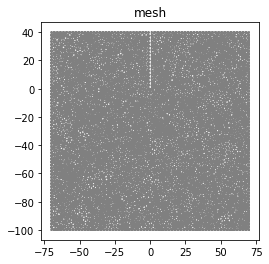

In [66]:
L = 0.5
R = 0.5
N = 50 # mesh density
domain = Rectangle(Point(-70.0,-100.0), Point(70.0, 40.0)) - Rectangle(Point(-1.0,0.0), Point(1.0, 40.95))
mesh = generate_mesh(domain, N)
plot ( mesh, title = 'mesh' )
mesh_points=mesh.coordinates()
print(mesh_points.shape)

In [67]:
Dphi = Constant(1.0)
E = 100000000
nu = 0.3
lmbda = Constant(E*nu/((1+nu)*(1-2*nu)))
mu = Constant(E/2/(1+nu))
# print(lmbda)

In [68]:
d = 1 # interpolation degree
Vue = VectorElement('CG', mesh.ufl_cell(), d) # displacement finite element
Vpe = FiniteElement('CG', mesh.ufl_cell(), d) # concentration finite element
V = FunctionSpace(mesh, MixedElement([Vue, Vpe]))

# Boundary conditions
def inner_b(x, on_boundary):
    return near(x[1], -0.0) and on_boundary
def inner_l(x, on_boundary):
    return near(x[0], -1.0) and on_boundary
def inner_r(x, on_boundary):
    return near(x[0], 1.0) and on_boundary
def bottom(x, on_boundary):
    return near(x[1], -100.0) and on_boundary
def left(x, on_boundary):
    return near(x[0], -70.0) and on_boundary
def right(x, on_boundary):
    return near(x[0], 70.0) and on_boundary
def top(x, on_boundary):
    return near(x[1], 40.0) and on_boundary
bc1 = DirichletBC(V.sub(1), Constant(0.), left)
bc2 = DirichletBC(V.sub(1), Constant(0.), right)
bc3 = DirichletBC(V.sub(1), Constant(0.), bottom)
bc4 = DirichletBC(V.sub(1), Constant(0.), top)
bc5 = DirichletBC(V.sub(1), Constant(0.), inner_l)
bc6 = DirichletBC(V.sub(1), Constant(0.), inner_r)
bc7 = DirichletBC(V.sub(0).sub(0), Constant(0.), left)
bc8 = DirichletBC(V.sub(0).sub(0), Constant(0.), right)
bc9 = DirichletBC(V.sub(0).sub(0), Constant(0.), bottom)
bc10 = DirichletBC(V.sub(0).sub(1), Constant(0.), left)
bc11 = DirichletBC(V.sub(0).sub(1), Constant(0.), right)
bc12 = DirichletBC(V.sub(0).sub(1), Constant(0.), bottom)
bc13 = DirichletBC(V.sub(1), Dphi, inner_b)

bcs = [bc1,bc2,bc3,bc7,bc8,bc9,bc10,bc11,bc12]

In [69]:
# Defining multiple Neumann boundary conditions 
mf = MeshFunction("size_t", mesh, 1)
mf.set_all(0) # initialize the function to zero
class inner_b(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0) and on_boundary
inner_b = inner_b() # instantiate it
inner_b.mark(mf, 1)
ds = ds(subdomain_data = mf)

In [70]:
U_ = TestFunction(V)  # P is the concentration or \rho
(u_, P_) = split(U_)
dU = TrialFunction(V)
(du, dP) = split(dU) 
U = Function(V)
(u, P) = split(U)

Un = Function(V)
(un, Pn) = split(Un)

In [71]:
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor

F = I + grad(u)             # Deformation gradient
C = F.T * F                # Elastic right Cauchy-Green tensor
Finv = inv(F)
k = 0.1            # Permeability of soil
phi = 0.1
R = 8.32
T = 398

# Invariants of deformation tensors
Ic = tr(C)
J = det(F)

psi = (1-phi)*((mu/2)*(Ic - tr(I)) - mu*ln(J) + (lmbda/2)*(ln(J))**2)-1*P*R*T*(1+1.5*ln(1.5*R*T)-ln(P*1/J))

F1 = (1-phi)* (mu * F - mu * Finv.T + lmbda*ln(J) * Finv.T) - 1*(P*R*T* Finv.T) # S

F1 = (1/J)*F.T * F1

par_psi_phi = phi*k*R*T*1*grad(P/J) #  J or flux

#  Define time things.
# dt = Constant(0.01)
Tt, num_steps = 20.0 , 50                   
dt = Tt / (1.0*num_steps)

y_BC = Expression(("0.0", "0.0"),degree=0)
u = project(y_BC,V.sub(0).collapse())

f = Expression(("0.0", "0.0"),degree=0) #Constant((0,-10)) for gas we ignore the gravity!
g = Expression(("500000.0"),degree=0)

mech_form = inner(F1, grad(u_))*dx + inner(1400*f,u_)*dx
phi_form = 1*J*inner(((par_psi_phi) + 6.5*f), grad(P_))*dx + ( P - Pn )*1/dt * P_ * dx - J*g*P_*ds(1)  
F = mech_form + phi_form
J = derivative(F, U, dU)

In [72]:
problem = NonlinearVariationalProblem(F, U, bcs, J)
solver  = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-8
prm['newton_solver']['relative_tolerance'] = 1E-5
prm['newton_solver']['maximum_iterations'] = 25
prm['newton_solver']['relaxation_parameter'] = 1.0

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [73]:

t = 0
for n in range(num_steps):
	print('n=',n)
	t += dt
	print('t=',t)
	solver.solve() # solve(F == 0, X0, bc)   
	    
	(u1, P1) = U.split()

	assign(Un,U)

n= 0
t= 0.4
n= 1
t= 0.8
n= 2
t= 1.2000000000000002
n= 3
t= 1.6
n= 4
t= 2.0
n= 5
t= 2.4
n= 6
t= 2.8
n= 7
t= 3.1999999999999997
n= 8
t= 3.5999999999999996
n= 9
t= 3.9999999999999996
n= 10
t= 4.3999999999999995
n= 11
t= 4.8
n= 12
t= 5.2
n= 13
t= 5.6000000000000005
n= 14
t= 6.000000000000001
n= 15
t= 6.400000000000001
n= 16
t= 6.800000000000002
n= 17
t= 7.200000000000002
n= 18
t= 7.600000000000002
n= 19
t= 8.000000000000002
n= 20
t= 8.400000000000002
n= 21
t= 8.800000000000002
n= 22
t= 9.200000000000003
n= 23
t= 9.600000000000003
n= 24
t= 10.000000000000004
n= 25
t= 10.400000000000004
n= 26
t= 10.800000000000004
n= 27
t= 11.200000000000005
n= 28
t= 11.600000000000005
n= 29
t= 12.000000000000005
n= 30
t= 12.400000000000006
n= 31
t= 12.800000000000006
n= 32
t= 13.200000000000006
n= 33
t= 13.600000000000007
n= 34
t= 14.000000000000007
n= 35
t= 14.400000000000007
n= 36
t= 14.800000000000008
n= 37
t= 15.200000000000008
n= 38
t= 15.600000000000009
n= 39
t= 16.000000000000007
n= 40
t= 16.40000000

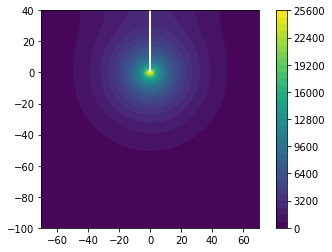

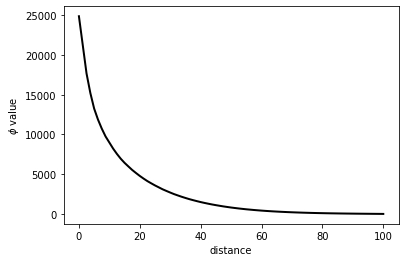

In [74]:
M=plot(P)
plt.colorbar(M)  
filename = 'Phidistribution.png'
plt.savefig ( filename )
plt.show()

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 81)
points = [(0 , -yy_ ) for yy_ in yy]  # 2D points

u_line = np.array([P(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$\phi$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('y.CSV',u_line)
np.savetxt('x.CSV',yy)

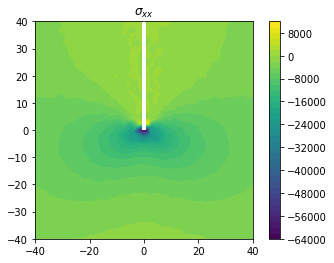

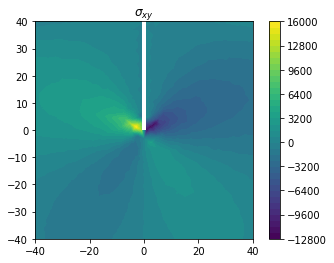

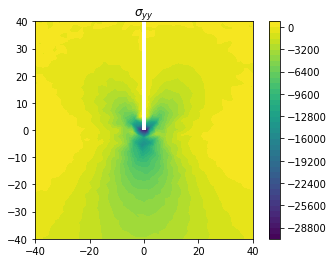

In [48]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)
sigma_w = project(  (1-phi)* (mu * inv(Finv) - mu * Finv.T + lmbda*ln(det(inv(Finv))) * Finv.T) - 1*((P)*R*T* Finv.T) , W)

M1 = plot(sigma_w[0,0]*0.001, title='$\sigma_{xx}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M1)
filename = 'xx.png'
plt.savefig ( filename )
plt.show()


M2 = plot(sigma_w[1,0]*0.001 ,title='$\sigma_{xy}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M2)
filename = 'xy.png'
plt.savefig ( filename )
plt.show()


M4 = plot(sigma_w[1,1]*0.001, title='$\sigma_{yy}$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M4)
filename = 'yy.png'
plt.savefig ( filename )
plt.show()


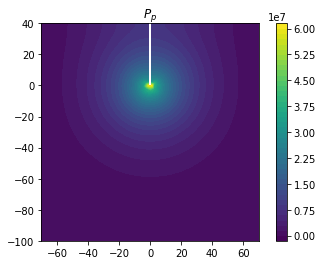

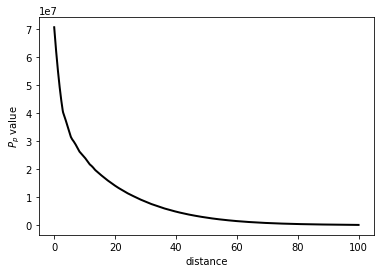

In [49]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

por_p = project((1/det(inv(Finv)))*P*R*T*Identity(2) , W)

M5 = plot(por_p[1,1], title='$P_p$')
plt.colorbar(M5)
plt.show()

P0 = por_p[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 100.0 - tol, 8001)
points = [(0.0 , -yy_ ) for yy_ in yy]  # 2D points
u_line = np.array([P0(point) for point in points])
plt.plot(yy, u_line, 'k', linewidth=2)
plt.ylabel('$P_p$ value')
plt.xlabel('distance')
plt.show()

np.savetxt('yp.CSV',u_line)
np.savetxt('xp.CSV',yy)


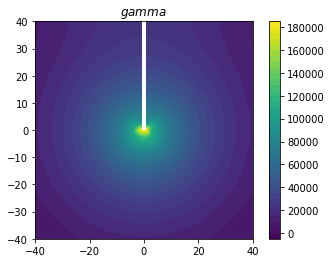

4.688455281308249e-06


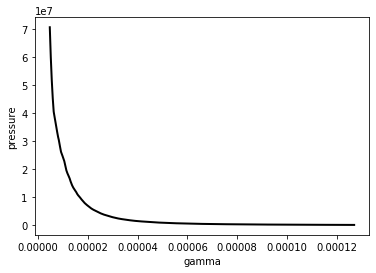

In [50]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)
gamma = P/(det(inv(Finv))*phi)
por_p2 = project(gamma*Identity(2) , W)

M5 = plot(por_p2[1,1], title='$gamma$')
plt.xlim((-40.0, 40.0))
plt.ylim((-40.0, 40.0))
plt.colorbar(M5)
plt.show()

P1 = por_p2[1,1]

tol = 0.001  # avoid hitting points outside the domain
yy = np.linspace(0.0 + tol, 50.0 - tol, 8001)
points = [(0. , -yy_ ) for yy_ in yy]  # 2D points
u_line1 = np.array([P1(point) for point in points])
u_line2 = 1/u_line1
print(np.min(u_line2))
plt.plot(u_line2, u_line , 'k', linewidth=2)
plt.ylabel('pressure')
plt.xlabel('gamma')
plt.show()

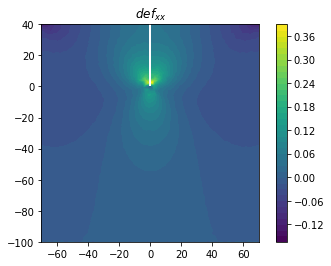

In [51]:
W = TensorFunctionSpace(mesh, "Lagrange", 2)

strain = (gradu + gradu.T)/2
deformation = project(strain , W)
u1 = deformation[0,0]

u1 = plot(deformation[0,0], title='$def_{xx}$')
plt.colorbar(u1)

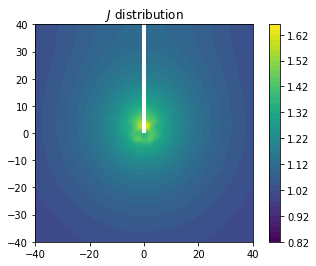

In [52]:
J = det(inv(Finv))
M=plot(J, title= '$J$ distribution')
plt.xlim((-40, 40))
plt.ylim((-40, 40))
plt.colorbar(M)  
filename = 'Phidistribution.png'
plt.savefig ( filename )
plt.show()